The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install -U mxnet-cu101==1.7.0
!pip install git+https://github.com/d2l-ai/d2l-zh@release  # installing d2l


# 线性回归
:label:`sec_linear_regression`

*回归*（regression）是能为一个或多个自变量与因变量之间关系建模的一类方法。
在自然科学和社会科学领域，回归经常用来表示输入和输出之间的关系。

在机器学习领域中的大多数任务通常都与*预测*（prediction）有关。
当我们想预测一个数值时，就会涉及到回归问题。
常见的例子包括：预测价格（房屋、股票等）、预测住院时间（针对住院病人等）、
预测需求（零售销量等）。
但不是所有的*预测*都是回归问题。
在后面的章节中，我们将介绍分类问题。分类问题的目标是预测数据属于一组类别中的哪一个。

## 线性回归的基本元素

*线性回归*（linear regression）可以追溯到19世纪初，
它在回归的各种标准工具中最简单而且最流行。
线性回归基于几个简单的假设：
首先，假设自变量$\mathbf{x}$和因变量$y$之间的关系是线性的，
即$y$可以表示为$\mathbf{x}$中元素的加权和，这里通常允许包含观测值的一些噪声；
其次，我们假设任何噪声都比较正常，如噪声遵循正态分布。

为了解释*线性回归*，我们举一个实际的例子：
我们希望根据房屋的面积（平方英尺）和房龄（年）来估算房屋价格（美元）。
为了开发一个能预测房价的模型，我们需要收集一个真实的数据集。
这个数据集包括了房屋的销售价格、面积和房龄。
在机器学习的术语中，该数据集称为*训练数据集*（training data set）
或*训练集*（training set）。
每行数据（比如一次房屋交易相对应的数据）称为*样本*（sample），
也可以称为*数据点*（data point）或*数据样本*（data instance）。
我们把试图预测的目标（比如预测房屋价格）称为*标签*（label）或*目标*（target）。
预测所依据的自变量（面积和房龄）称为*特征*（feature）或*协变量*（covariate）。

通常，我们使用$n$来表示数据集中的样本数。
对索引为$i$的样本，其输入表示为$\mathbf{x}^{(i)} = [x_1^{(i)}, x_2^{(i)}]^\top$，
其对应的标签是$y^{(i)}$。

### 线性模型
:label:`subsec_linear_model`

线性假设是指目标（房屋价格）可以表示为特征（面积和房龄）的加权和，如下面的式子：

$$\mathrm{price} = w_{\mathrm{area}} \cdot \mathrm{area} + w_{\mathrm{age}} \cdot \mathrm{age} + b.$$
:eqlabel:`eq_price-area`

 :eqref:`eq_price-area`中的$w_{\mathrm{area}}$和$w_{\mathrm{age}}$
称为*权重*（weight），权重决定了每个特征对我们预测值的影响。
$b$称为*偏置*（bias）、*偏移量*（offset）或*截距*（intercept）。
偏置是指当所有特征都取值为0时，预测值应该为多少。
即使现实中不会有任何房子的面积是0或房龄正好是0年，我们仍然需要偏置项。
如果没有偏置项，我们模型的表达能力将受到限制。
严格来说， :eqref:`eq_price-area`是输入特征的一个
*仿射变换*（affine transformation）。
仿射变换的特点是通过加权和对特征进行*线性变换*（linear transformation），
并通过偏置项来进行*平移*（translation）。

给定一个数据集，我们的目标是寻找模型的权重$\mathbf{w}$和偏置$b$，
使得根据模型做出的预测大体符合数据里的真实价格。
输出的预测值由输入特征通过*线性模型*的仿射变换决定，仿射变换由所选权重和偏置确定。

而在机器学习领域，我们通常使用的是高维数据集，建模时采用线性代数表示法会比较方便。
当我们的输入包含$d$个特征时，我们将预测结果$\hat{y}$
（通常使用“尖角”符号表示$y$的估计值）表示为：

$$\hat{y} = w_1  x_1 + ... + w_d  x_d + b.$$

将所有特征放到向量$\mathbf{x} \in \mathbb{R}^d$中，
并将所有权重放到向量$\mathbf{w} \in \mathbb{R}^d$中，
我们可以用点积形式来简洁地表达模型：

$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$
:eqlabel:`eq_linreg-y`

在 :eqref:`eq_linreg-y`中，
向量$\mathbf{x}$对应于单个数据样本的特征。
用符号表示的矩阵$\mathbf{X} \in \mathbb{R}^{n \times d}$
可以很方便地引用我们整个数据集的$n$个样本。
其中，$\mathbf{X}$的每一行是一个样本，每一列是一种特征。

对于特征集合$\mathbf{X}$，预测值$\hat{\mathbf{y}} \in \mathbb{R}^n$
可以通过矩阵-向量乘法表示为：

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b$$

这个过程中的求和将使用广播机制
（广播机制在 :numref:`subsec_broadcasting`中有详细介绍）。
给定训练数据特征$\mathbf{X}$和对应的已知标签$\mathbf{y}$，
线性回归的目标是找到一组权重向量$\mathbf{w}$和偏置$b$：
当给定从$\mathbf{X}$的同分布中取样的新样本特征时，
这组权重向量和偏置能够使得新样本预测标签的误差尽可能小。

虽然我们相信给定$\mathbf{x}$预测$y$的最佳模型会是线性的，
但我们很难找到一个有$n$个样本的真实数据集，其中对于所有的$1 \leq i \leq n$，$y^{(i)}$完全等于$\mathbf{w}^\top \mathbf{x}^{(i)}+b$。
无论我们使用什么手段来观察特征$\mathbf{X}$和标签$\mathbf{y}$，
都可能会出现少量的观测误差。
因此，即使确信特征与标签的潜在关系是线性的，
我们也会加入一个噪声项来考虑观测误差带来的影响。

在开始寻找最好的*模型参数*（model parameters）$\mathbf{w}$和$b$之前，
我们还需要两个东西：
（1）一种模型质量的度量方式；
（2）一种能够更新模型以提高模型预测质量的方法。

### 损失函数

在我们开始考虑如何用模型*拟合*（fit）数据之前，我们需要确定一个拟合程度的度量。
*损失函数*（loss function）能够量化目标的*实际*值与*预测*值之间的差距。
通常我们会选择非负数作为损失，且数值越小表示损失越小，完美预测时的损失为0。
回归问题中最常用的损失函数是平方误差函数。
当样本$i$的预测值为$\hat{y}^{(i)}$，其相应的真实标签为$y^{(i)}$时，
平方误差可以定义为以下公式：

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$
:eqlabel:`eq_mse`

常数$\frac{1}{2}$不会带来本质的差别，但这样在形式上稍微简单一些
（因为当我们对损失函数求导后常数系数为1）。
由于训练数据集并不受我们控制，所以经验误差只是关于模型参数的函数。
为了进一步说明，来看下面的例子。
我们为一维情况下的回归问题绘制图像，如 :numref:`fig_fit_linreg`所示。

![用线性模型拟合数据。](../img/fit-linreg.svg)
:label:`fig_fit_linreg`

由于平方误差函数中的二次方项，
估计值$\hat{y}^{(i)}$和观测值$y^{(i)}$之间较大的差异将导致更大的损失。
为了度量模型在整个数据集上的质量，我们需计算在训练集$n$个样本上的损失均值（也等价于求和）。

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

在训练模型时，我们希望寻找一组参数（$\mathbf{w}^*, b^*$），
这组参数能最小化在所有训练样本上的总损失。如下式：

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$

### 解析解

线性回归刚好是一个很简单的优化问题。
与我们将在本书中所讲到的其他大部分模型不同，线性回归的解可以用一个公式简单地表达出来，
这类解叫作解析解（analytical solution）。
首先，我们将偏置$b$合并到参数$\mathbf{w}$中，合并方法是在包含所有参数的矩阵中附加一列。
我们的预测问题是最小化$\|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2$。
这在损失平面上只有一个临界点，这个临界点对应于整个区域的损失极小点。
将损失关于$\mathbf{w}$的导数设为0，得到解析解：

$$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}.$$

像线性回归这样的简单问题存在解析解，但并不是所有的问题都存在解析解。
解析解可以进行很好的数学分析，但解析解对问题的限制很严格，导致它无法广泛应用在深度学习里。

### 随机梯度下降

即使在我们无法得到解析解的情况下，我们仍然可以有效地训练模型。
在许多任务上，那些难以优化的模型效果要更好。
因此，弄清楚如何训练这些难以优化的模型是非常重要的。

本书中我们用到一种名为*梯度下降*（gradient descent）的方法，
这种方法几乎可以优化所有深度学习模型。
它通过不断地在损失函数递减的方向上更新参数来降低误差。

梯度下降最简单的用法是计算损失函数（数据集中所有样本的损失均值）
关于模型参数的导数（在这里也可以称为梯度）。
但实际中的执行可能会非常慢：因为在每一次更新参数之前，我们必须遍历整个数据集。
因此，我们通常会在每次需要计算更新的时候随机抽取一小批样本，
这种变体叫做*小批量随机梯度下降*（minibatch stochastic gradient descent）。

在每次迭代中，我们首先随机抽样一个小批量$\mathcal{B}$，
它是由固定数量的训练样本组成的。
然后，我们计算小批量的平均损失关于模型参数的导数（也可以称为梯度）。
最后，我们将梯度乘以一个预先确定的正数$\eta$，并从当前参数的值中减掉。

我们用下面的数学公式来表示这一更新过程（$\partial$表示偏导数）：

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$

总结一下，算法的步骤如下：
（1）初始化模型参数的值，如随机初始化；
（2）从数据集中随机抽取小批量样本且在负梯度的方向上更新参数，并不断迭代这一步骤。
对于平方损失和仿射变换，我们可以明确地写成如下形式:

$$\begin{aligned} \mathbf{w} &\leftarrow \mathbf{w} -   \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right),\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \partial_b l^{(i)}(\mathbf{w}, b)  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}$$
:eqlabel:`eq_linreg_batch_update`

公式 :eqref:`eq_linreg_batch_update`中的$\mathbf{w}$和$\mathbf{x}$都是向量。
在这里，更优雅的向量表示法比系数表示法（如$w_1, w_2, \ldots, w_d$）更具可读性。
$|\mathcal{B}|$表示每个小批量中的样本数，这也称为*批量大小*（batch size）。
$\eta$表示*学习率*（learning rate）。
批量大小和学习率的值通常是手动预先指定，而不是通过模型训练得到的。
这些可以调整但不在训练过程中更新的参数称为*超参数*（hyperparameter）。
*调参*（hyperparameter tuning）是选择超参数的过程。
超参数通常是我们根据训练迭代结果来调整的，
而训练迭代结果是在独立的*验证数据集*（validation dataset）上评估得到的。

在训练了预先确定的若干迭代次数后（或者直到满足某些其他停止条件后），
我们记录下模型参数的估计值，表示为$\hat{\mathbf{w}}, \hat{b}$。
但是，即使我们的函数确实是线性的且无噪声，这些估计值也不会使损失函数真正地达到最小值。
因为算法会使得损失向最小值缓慢收敛，但却不能在有限的步数内非常精确地达到最小值。

线性回归恰好是一个在整个域中只有一个最小值的学习问题。
但是对于像深度神经网络这样复杂的模型来说，损失平面上通常包含多个最小值。
深度学习实践者很少会去花费大力气寻找这样一组参数，使得在*训练集*上的损失达到最小。
事实上，更难做到的是找到一组参数，这组参数能够在我们从未见过的数据上实现较低的损失，
这一挑战被称为*泛化*（generalization）。

### 用模型进行预测

给定“已学习”的线性回归模型$\hat{\mathbf{w}}^\top \mathbf{x} + \hat{b}$，
现在我们可以通过房屋面积$x_1$和房龄$x_2$来估计一个（未包含在训练数据中的）新房屋价格。
给定特征估计目标的过程通常称为*预测*（prediction）或*推断*（inference）。

本书将尝试坚持使用*预测*这个词。
虽然*推断*这个词已经成为深度学习的标准术语，但其实*推断*这个词有些用词不当。
在统计学中，*推断*更多地表示基于数据集估计参数。
当深度学习从业者与统计学家交谈时，术语的误用经常导致一些误解。

## 矢量化加速

在训练我们的模型时，我们经常希望能够同时处理整个小批量的样本。
为了实现这一点，需要(**我们对计算进行矢量化，
从而利用线性代数库，而不是在Python中编写开销高昂的for循环**)。


In [1]:
%matplotlib inline
import math
import time
from mxnet import np
from d2l import mxnet as d2l

为了说明矢量化为什么如此重要，我们考虑(**对向量相加的两种方法**)。
我们实例化两个全为1的10000维向量。
在一种方法中，我们将使用Python的for循环遍历向量；
在另一种方法中，我们将依赖对`+`的调用。


In [2]:
n = 10000
a = np.ones(n)
b = np.ones(n)

由于在本书中我们将频繁地进行运行时间的基准测试，所以[**我们定义一个计时器**]：


In [3]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

现在我们可以对工作负载进行基准测试。

首先，[**我们使用for循环，每次执行一位的加法**]。


In [4]:
c = np.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'3.99902 sec'

(**或者，我们使用重载的`+`运算符来计算按元素的和**)。


In [5]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00024 sec'

结果很明显，第二种方法比第一种方法快得多。
矢量化代码通常会带来数量级的加速。
另外，我们将更多的数学运算放到库中，而无须自己编写那么多的计算，从而减少了出错的可能性。

## 正态分布与平方损失
:label:`subsec_normal_distribution_and_squared_loss`

接下来，我们通过对噪声分布的假设来解读平方损失目标函数。

正态分布和线性回归之间的关系很密切。
正态分布（normal distribution），也称为*高斯分布*（Gaussian distribution），
最早由德国数学家高斯（Gauss）应用于天文学研究。
简单的说，若随机变量$x$具有均值$\mu$和方差$\sigma^2$（标准差$\sigma$），其正态分布概率密度函数如下：

$$p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (x - \mu)^2\right).$$

下面[**我们定义一个Python函数来计算正态分布**]。


In [6]:
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

我们现在(**可视化正态分布**)。


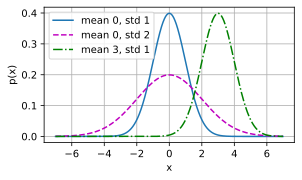

In [7]:
# 再次使用numpy进行可视化
x = np.arange(-7, 7, 0.01)

# 均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

就像我们所看到的，改变均值会产生沿$x$轴的偏移，增加方差将会分散分布、降低其峰值。

均方误差损失函数（简称均方损失）可以用于线性回归的一个原因是：
我们假设了观测中包含噪声，其中噪声服从正态分布。
噪声正态分布如下式:

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon,$$

其中，$\epsilon \sim \mathcal{N}(0, \sigma^2)$。

因此，我们现在可以写出通过给定的$\mathbf{x}$观测到特定$y$的*似然*（likelihood）：

$$P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

现在，根据极大似然估计法，参数$\mathbf{w}$和$b$的最优值是使整个数据集的*似然*最大的值：

$$P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)}|\mathbf{x}^{(i)}).$$

根据极大似然估计法选择的估计量称为*极大似然估计量*。
虽然使许多指数函数的乘积最大化看起来很困难，
但是我们可以在不改变目标的前提下，通过最大化似然对数来简化。
由于历史原因，优化通常是说最小化而不是最大化。
我们可以改为*最小化负对数似然*$-\log P(\mathbf y \mid \mathbf X)$。
由此可以得到的数学公式是：

$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

现在我们只需要假设$\sigma$是某个固定常数就可以忽略第一项，
因为第一项不依赖于$\mathbf{w}$和$b$。
现在第二项除了常数$\frac{1}{\sigma^2}$外，其余部分和前面介绍的均方误差是一样的。
幸运的是，上面式子的解并不依赖于$\sigma$。
因此，在高斯噪声的假设下，最小化均方误差等价于对线性模型的极大似然估计。

## 从线性回归到深度网络

到目前为止，我们只谈论了线性模型。
尽管神经网络涵盖了更多更为丰富的模型，我们依然可以用描述神经网络的方式来描述线性模型，
从而把线性模型看作一个神经网络。
首先，我们用“层”符号来重写这个模型。

### 神经网络图

深度学习从业者喜欢绘制图表来可视化模型中正在发生的事情。
在 :numref:`fig_single_neuron`中，我们将线性回归模型描述为一个神经网络。
需要注意的是，该图只显示连接模式，即只显示每个输入如何连接到输出，隐去了权重和偏置的值。

![线性回归是一个单层神经网络。](http://d2l.ai/_images/singleneuron.svg)
:label:`fig_single_neuron`

在 :numref:`fig_single_neuron`所示的神经网络中，输入为$x_1, \ldots, x_d$，
因此输入层中的*输入数*（或称为*特征维度*，feature dimensionality）为$d$。
网络的输出为$o_1$，因此输出层中的*输出数*是1。
需要注意的是，输入值都是已经给定的，并且只有一个*计算*神经元。
由于模型重点在发生计算的地方，所以通常我们在计算层数时不考虑输入层。
也就是说， :numref:`fig_single_neuron`中神经网络的*层数*为1。
我们可以将线性回归模型视为仅由单个人工神经元组成的神经网络，或称为单层神经网络。

对于线性回归，每个输入都与每个输出（在本例中只有一个输出）相连，
我们将这种变换（ :numref:`fig_single_neuron`中的输出层）
称为*全连接层*（fully-connected layer）或称为*稠密层*（dense layer）。
下一章将详细讨论由这些层组成的网络。

### 生物学

线性回归发明的时间（1795年）早于计算神经科学，所以将线性回归描述为神经网络似乎不合适。
当控制学家、神经生物学家沃伦·麦库洛奇和沃尔特·皮茨开始开发人工神经元模型时，
他们为什么将线性模型作为一个起点呢？
我们来看一张图片 :numref:`fig_Neuron`：
这是一张由*树突*（dendrites，输入终端）、
*细胞核*（nucleu，CPU）组成的生物神经元图片。
*轴突*（axon，输出线）和*轴突端子*（axon terminal，输出端子）
通过*突触*（synapse）与其他神经元连接。

![真实的神经元。](http://d2l.ai/_images/neuron.svg)
:label:`fig_Neuron`

树突中接收到来自其他神经元（或视网膜等环境传感器）的信息$x_i$。
该信息通过*突触权重*$w_i$来加权，以确定输入的影响（即，通过$x_i w_i$相乘来激活或抑制）。
来自多个源的加权输入以加权和$y = \sum_i x_i w_i + b$的形式汇聚在细胞核中，
然后将这些信息发送到轴突$y$中进一步处理，通常会通过$\sigma(y)$进行一些非线性处理。
之后，它要么到达目的地（例如肌肉），要么通过树突进入另一个神经元。

当然，许多这样的单元可以通过正确连接和正确的学习算法拼凑在一起，
从而产生的行为会比单独一个神经元所产生的行为更有趣、更复杂，
这种想法归功于我们对真实生物神经系统的研究。

当今大多数深度学习的研究几乎没有直接从神经科学中获得灵感。
我们援引斯图尔特·罗素和彼得·诺维格谁，在他们的经典人工智能教科书
*Artificial Intelligence:A Modern Approach* :cite:`Russell.Norvig.2016`
中所说：虽然飞机可能受到鸟类的启发，但几个世纪以来，鸟类学并不是航空创新的主要驱动力。
同样地，如今在深度学习中的灵感同样或更多地来自数学、统计学和计算机科学。

## 小结

* 机器学习模型中的关键要素是训练数据、损失函数、优化算法，还有模型本身。
* 矢量化使数学表达上更简洁，同时运行的更快。
* 最小化目标函数和执行极大似然估计等价。
* 线性回归模型也是一个简单的神经网络。

## 练习

1. 假设我们有一些数据$x_1, \ldots, x_n \in \mathbb{R}$。我们的目标是找到一个常数$b$，使得最小化$\sum_i (x_i - b)^2$。
    1. 找到最优值$b$的解析解。
    1. 这个问题及其解与正态分布有什么关系?
1. 推导出使用平方误差的线性回归优化问题的解析解。为了简化问题，可以忽略偏置$b$（我们可以通过向$\mathbf X$添加所有值为1的一列来做到这一点）。
    1. 用矩阵和向量表示法写出优化问题（将所有数据视为单个矩阵，将所有目标值视为单个向量）。
    1. 计算损失对$w$的梯度。
    1. 通过将梯度设为0、求解矩阵方程来找到解析解。
    1. 什么时候可能比使用随机梯度下降更好？这种方法何时会失效？
1. 假定控制附加噪声$\epsilon$的噪声模型是指数分布。也就是说，$p(\epsilon) = \frac{1}{2} \exp(-|\epsilon|)$
    1. 写出模型$-\log P(\mathbf y \mid \mathbf X)$下数据的负对数似然。
    1. 你能写出解析解吗？
    1. 提出一种随机梯度下降算法来解决这个问题。哪里可能出错？（提示：当我们不断更新参数时，在驻点附近会发生什么情况）你能解决这个问题吗？


[Discussions](https://discuss.d2l.ai/t/1774)
